# Molecular Graph Autoencoder

This block

- imports all modules/libraries needed
- contains a function for a learning rate scheduler (if needed)
- reads in SMILES strings and creates a list
- featurizes via the SmilesTo Image featurizer from Deepchem (https://github.com/deepchem/deepchem)
- Four channel image used for featurization
  * Atomic numbers + bonds
  * partial charges
  * valence
  * hybridization

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import deepchem as dc
import time
from rdkit import Chem
from functools import partial
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, Draw
from sklearn.model_selection import train_test_split

def exp_decay(lr0,s):
    def exp_decay_fcn(epoch):
        return lr0*0.1**(epoch/s)
    return exp_decay_fcn

#df = pd.read_csv("392-azo.csv")
#df = pd.read_csv("212-azo.csv")
#df = pd.read_csv("604-azo.csv")
#df = pd.read_csv("621-azo.csv")
df = pd.read_csv("6731-azo.csv")

Xa = [""]*len(df)
w = [""]*len(df)
i=0
for name in df["SMILES"]:
    Xa[i]=name
    w[i]=1.0
    i += 1
Xa = list(Xa)
w=list(w)

#===========================================================================================
#featurizer

featurizer=dc.feat.SmilesToImage(img_spec="engd")
featname="SmilesToImage"

f = featurizer.featurize(Xa)
print("Number of features and datapoints: ",f.shape)

#===========================================================================================
print("featurization done with: ",featname)

# set npp for how many points in the dataset, len(df) for whole dataset
nnp=len(df)

#set y to lambdamax
y = df["Lmax"]

#set dataset and split

dataset = dc.data.NumpyDataset(X=f[:nnp,:,:,:], y=y[:nnp], ids=Xa[:nnp], w=w[:nnp])


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (C:\ProgramData\Anaconda3\envs\rdkitenv\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading some Jax models, missing a dependency. No module named 'jax'


Number of features and datapoints:  (6731, 80, 80, 4)
featurization done with:  SmilesToImage


## Dense layer Autoencoder

- encoder flattens the images, then passes through a larger dense layer, and then the bottleneck
- bottleneck produces the "encodings"
- decoder takes encoder output, expands it back to the original size, and refits it to the original dimensions

In [18]:
act= "relu"
alpha = 0.0
alphae = 0.0

encoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[80,80,4]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation=act,kernel_regularizer=tf.keras.regularizers.l2(alphae)),
    tf.keras.layers.Dense(64,activation=act,kernel_regularizer=tf.keras.regularizers.l2(alphae)),
    tf.keras.layers.Dense(32,activation=act,kernel_regularizer=tf.keras.regularizers.l2(alphae))])

decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(64,activation=act,kernel_regularizer=tf.keras.regularizers.l2(alpha)),
    tf.keras.layers.Dense(128,activation=act,kernel_regularizer=tf.keras.regularizers.l2(alpha)),
    tf.keras.layers.Dense(25600,activation="sigmoid"),
    tf.keras.layers.Reshape([80,80,4])])

autoencoder = tf.keras.Sequential([encoder,decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9)
autoencoder.compile(loss="mean_squared_error",optimizer=optimizer,metrics=["mse"])
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(r"StIAE/sTIAE",monitor="val_mse",save_best_only=True)

history = autoencoder.fit(dataset.X,dataset.X,epochs=25,verbose=2,validation_split=0.1,callbacks=[checkpoint_cb])

Epoch 1/25
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 10s - loss: 0.3081 - mse: 0.3081 - val_loss: 0.3054 - val_mse: 0.3054 - 10s/epoch - 54ms/step
Epoch 2/25
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 5s - loss: 0.3080 - mse: 0.3080 - val_loss: 0.3053 - val_mse: 0.3053 - 5s/epoch - 27ms/step
Epoch 3/25
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 5s - loss: 0.3080 - mse: 0.3080 - val_loss: 0.3052 - val_mse: 0.3052 - 5s/epoch - 26ms/step
Epoch 4/25
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 5s - loss: 0.3079 - mse: 0.3079 - val_loss: 0.3051 - val_mse: 0.3051 - 5s/epoch - 27ms/step
Epoch 5/25
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 5s - loss: 0.3078 - mse: 0.3078 - val_loss: 0.3051 - val_mse: 0.3051 - 5s/epoch - 29ms/step
Epoch 6/25
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 8s - loss: 0.3077 - mse: 0.3077 - val_loss: 0.3050 - val_mse: 0.3050 - 8s/epoch - 40ms/step
Epoch 7/25
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 6s - loss: 0.3076 - mse: 0.3076 - val_loss: 0.3048 - val_mse: 0.3048 - 6s/epoch - 29ms/step
Epoch 8/25
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 5s - loss: 0.3074 - mse: 0.3074 - val_loss: 0.3046 - val_mse: 0.3046 - 5s/epoch - 28ms/step
Epoch 9/25
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 10s - loss: 0.3070 - mse: 0.3070 - val_loss: 0.3041 - val_mse: 0.3041 - 10s/epoch - 50ms/step
Epoch 10/25
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 5s - loss: 0.3063 - mse: 0.3063 - val_loss: 0.3029 - val_mse: 0.3029 - 5s/epoch - 25ms/step
Epoch 11/25
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 5s - loss: 0.3040 - mse: 0.3040 - val_loss: 0.2987 - val_mse: 0.2987 - 5s/epoch - 25ms/step
Epoch 12/25
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 4s - loss: 0.2908 - mse: 0.2908 - val_loss: 0.2633 - val_mse: 0.2633 - 4s/epoch - 24ms/step
Epoch 13/25
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 5s - loss: 0.1630 - mse: 0.1630 - val_loss: 0.0705 - val_mse: 0.0705 - 5s/epoch - 24ms/step
Epoch 14/25
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 5s - loss: 0.0711 - mse: 0.0711 - val_loss: 0.0650 - val_mse: 0.0650 - 5s/epoch - 24ms/step
Epoch 15/25
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 5s - loss: 0.0694 - mse: 0.0694 - val_loss: 0.0646 - val_mse: 0.0646 - 5s/epoch - 24ms/step
Epoch 16/25
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 4s - loss: 0.0691 - mse: 0.0691 - val_loss: 0.0644 - val_mse: 0.0644 - 4s/epoch - 24ms/step
Epoch 17/25
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 5s - loss: 0.0689 - mse: 0.0689 - val_loss: 0.0644 - val_mse: 0.0644 - 5s/epoch - 24ms/step
Epoch 18/25
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 5s - loss: 0.0688 - mse: 0.0688 - val_loss: 0.0643 - val_mse: 0.0643 - 5s/epoch - 25ms/step
Epoch 19/25
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 6s - loss: 0.0688 - mse: 0.0688 - val_loss: 0.0643 - val_mse: 0.0643 - 6s/epoch - 34ms/step
Epoch 20/25
190/190 - 4s - loss: 0.0687 - mse: 0.0687 - val_loss: 0.0643 - val_mse: 0.0643 - 4s/epoch - 19ms/step
Epoch 21/25
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 4s - loss: 0.0687 - mse: 0.0687 - val_loss: 0.0643 - val_mse: 0.0643 - 4s/epoch - 23ms/step
Epoch 22/25
190/190 - 3s - loss: 0.0687 - mse: 0.0687 - val_loss: 0.0643 - val_mse: 0.0643 - 3s/epoch - 18ms/step
Epoch 23/25
190/190 - 3s - loss: 0.0686 - mse: 0.0686 - val_loss: 0.0643 - val_mse: 0.0643 - 3s/epoch - 17ms/step
Epoch 24/25
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 5s - loss: 0.0686 - mse: 0.0686 - val_loss: 0.0642 - val_mse: 0.0642 - 5s/epoch - 24ms/step
Epoch 25/25
190/190 - 3s - loss: 0.0686 - mse: 0.0686 - val_loss: 0.0642 - val_mse: 0.0642 - 3s/epoch - 17ms/step


## Save a model

In [36]:
autoencoder.save("6731_128_64_32_MSE1200",save_format="tf")
print("model saved.")

INFO:tensorflow:Assets written to: 6731_128_64_32_MSE1200\assets


INFO:tensorflow:Assets written to: 6731_128_64_32_MSE1200\assets


model saved.


## Load a model and restart training

In [34]:
autoencoder = tf.keras.models.load_model("6731_128_64_32_MSE800")

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.9)
autoencoder.compile(loss="mean_squared_error",optimizer=optimizer,metrics=["mse"])
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(r"StIAE/sTIAE",monitor="val_mse",save_best_only=True)

history = autoencoder.fit(dataset.X,dataset.X,epochs=1200,verbose=2,validation_split=0.1,initial_epoch=800,callbacks=[checkpoint_cb])

Epoch 801/1200
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 14s - loss: 0.0573 - mse: 0.0573 - val_loss: 0.0589 - val_mse: 0.0589 - 14s/epoch - 74ms/step
Epoch 802/1200
190/190 - 3s - loss: 0.0573 - mse: 0.0573 - val_loss: 0.0589 - val_mse: 0.0589 - 3s/epoch - 18ms/step
Epoch 803/1200
INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


INFO:tensorflow:Assets written to: StIAE\sTIAE\assets


190/190 - 6s - loss: 0.0573 - mse: 0.0573 - val_loss: 0.0589 - val_mse: 0.0589 - 6s/epoch - 30ms/step
Epoch 804/1200
190/190 - 3s - loss: 0.0572 - mse: 0.0572 - val_loss: 0.0589 - val_mse: 0.0589 - 3s/epoch - 17ms/step
Epoch 805/1200
190/190 - 3s - loss: 0.0572 - mse: 0.0572 - val_loss: 0.0589 - val_mse: 0.0589 - 3s/epoch - 17ms/step
Epoch 806/1200
190/190 - 3s - loss: 0.0572 - mse: 0.0572 - val_loss: 0.0589 - val_mse: 0.0589 - 3s/epoch - 18ms/step
Epoch 807/1200
190/190 - 3s - loss: 0.0572 - mse: 0.0572 - val_loss: 0.0589 - val_mse: 0.0589 - 3s/epoch - 17ms/step
Epoch 808/1200
190/190 - 3s - loss: 0.0572 - mse: 0.0572 - val_loss: 0.0589 - val_mse: 0.0589 - 3s/epoch - 17ms/step
Epoch 809/1200
190/190 - 3s - loss: 0.0572 - mse: 0.0572 - val_loss: 0.0589 - val_mse: 0.0589 - 3s/epoch - 17ms/step
Epoch 810/1200
190/190 - 3s - loss: 0.0572 - mse: 0.0572 - val_loss: 0.0590 - val_mse: 0.0590 - 3s/epoch - 18ms/step
Epoch 811/1200
190/190 - 3s - loss: 0.0572 - mse: 0.0572 - val_loss: 0.0590 - v

## Plot original image versus image reconstructed with the model

- new_images function takes an image from the featurizer and runs it through the autoencoder
- resulting image is the reconstructed image from the model, showing the selected channel
- old_images takes the image from the featurizer and shows the selected channel
- options for rotation and cropping are also available in the above two functions
- plots original image on top, channel by channel, and reconstructed image on the bottom, channel by channel

1/1 [==============================] - 0s 66ms/step


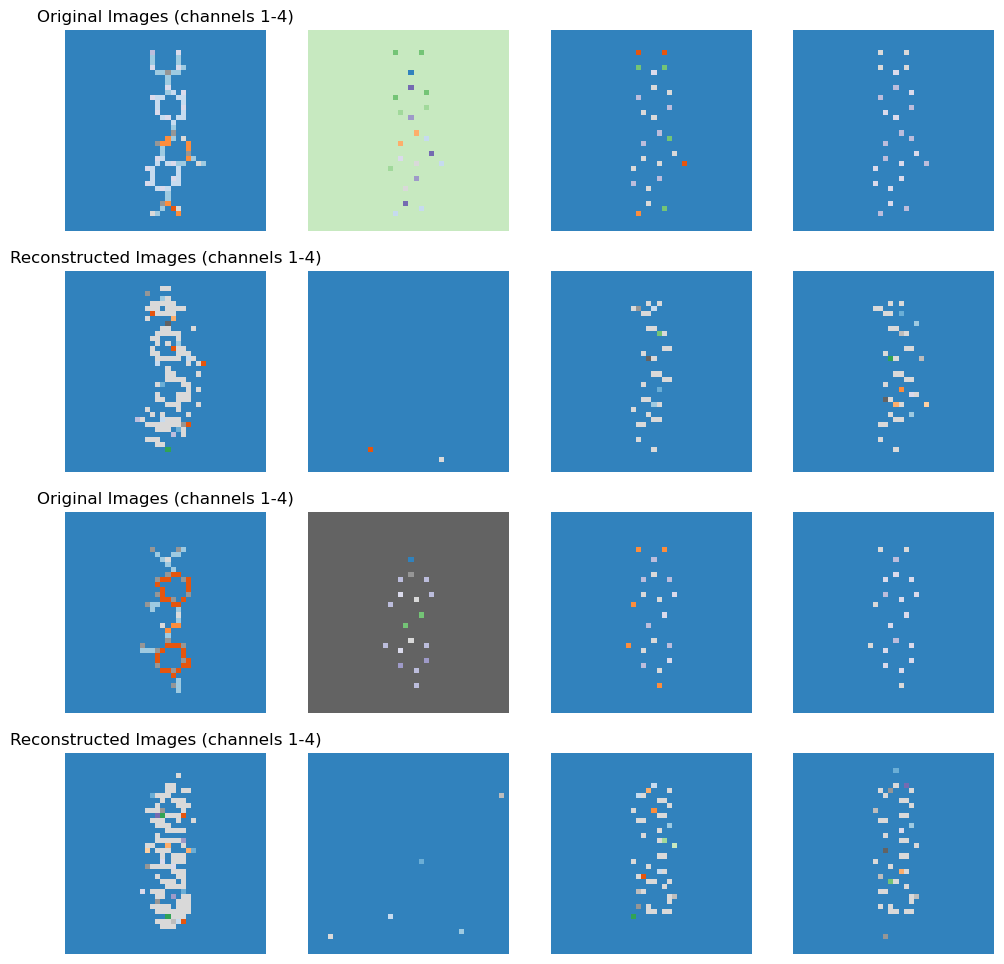

In [7]:
from matplotlib import pyplot as plt
from scipy import ndimage

#load a model
autoencoder = tf.keras.models.load_model("6731_128_64_32_MSE1200")
#switch to convolutional autoencoder
#autoencoder = cautoencoder

cmap="tab20c"

def new_images(model,image,channel):
    recons = model.predict(image)[0,:,:,channel] #last number cycles through channels 0-3
    rot = ndimage.rotate(recons, 0)
    rot = rot[20:60, 20:60]
    return rot

def old_images(model,image,channel):
    recons = image[0,:,:,channel] #last number cycles through channels 0-3
    rot = ndimage.rotate(recons, 0)
    rot  = rot[20:60, 20:60]
    return rot
    
m1=featurizer.featurize("[H]C1=CC([N+]([O-])=O)=CC([N+]([O-])=O)=C1/N=N/C2=CC([H])=C(C=C2[H])N(CC)CC")
m2=featurizer.featurize("CC1=C(/N=N/C2=CC=C(N(C)C)C=C2C)C=CC(C)=C1")

newimages=[]
oldimages=[]
newimages2=[]
oldimages2=[]
for i in range(4):
    new1 = new_images(model=autoencoder,image=m1,channel=i)
    old1 = old_images(model=autoencoder,image=m1,channel=i)
    newimages.append(new1)
    oldimages.append(old1)
    new1 = new_images(model=autoencoder,image=m2,channel=i)
    old1 = old_images(model=autoencoder,image=m2,channel=i)
    newimages2.append(new1)
    oldimages2.append(old1)

#can insert scaling code here

fig, arrax = plt.subplots(4, 4, figsize=(12,12))
for i in range(4):
    arrax[0,i].imshow(oldimages[i],cmap=cmap)
    arrax[1,i].imshow(newimages[i],cmap=cmap)
    arrax[2,i].imshow(oldimages2[i],cmap=cmap)
    arrax[3,i].imshow(newimages2[i],cmap=cmap)
    arrax[0,i].axis("off")
    arrax[1,i].axis("off")
    arrax[2,i].axis("off")
    arrax[3,i].axis("off")
arrax[0,0].set_title("Original Images (channels 1-4)")
arrax[1,0].set_title("Reconstructed Images (channels 1-4)")
arrax[2,0].set_title("Original Images (channels 1-4)")
arrax[3,0].set_title("Reconstructed Images (channels 1-4)")

plt.show()

## Convolutional Autoencoder

- uses Conv2D and MaxPooling in the encoder, Conv2DTranspose for the decoder
- 4 channel images from SmilesToImage from DeepChem
- regularization (l2) included and padding="same"

In [8]:
act= "relu"
alphac = 0.0

cencoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[80,80,4]),
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding="same", activation=act,
                           kernel_regularizer=tf.keras.regularizers.l2(alphac)),
    tf.keras.layers.MaxPooling2D((2,2),padding="same"),
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation=act,padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(alphac)),
    tf.keras.layers.MaxPooling2D((2,2),padding="same")])

cdecoder = tf.keras.Sequential([
    tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(3,3),strides=2,activation=act,padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(alphac)),
     tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(3,3),strides=2,activation=act,padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(alphac)),
    tf.keras.layers.Conv2D(4,kernel_size=(3,3),activation="sigmoid",padding="same")])

cautoencoder = tf.keras.Sequential([cencoder,cdecoder])

coptimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(r"ConvAE/ConvAE",monitor="val_mse",save_best_only=True)
cautoencoder.compile(loss="mean_squared_error",optimizer=coptimizer,metrics=["mse"])

history = cautoencoder.fit(dataset.X,dataset.X,epochs=50,verbose=2,validation_split=0.1,callbacks=[checkpoint_cb])

Epoch 1/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 21s - loss: 0.1332 - mse: 0.1332 - val_loss: 0.0734 - val_mse: 0.0734 - 21s/epoch - 111ms/step
Epoch 2/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 21s - loss: 0.0758 - mse: 0.0758 - val_loss: 0.0707 - val_mse: 0.0707 - 21s/epoch - 113ms/step
Epoch 3/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 15s - loss: 0.0747 - mse: 0.0747 - val_loss: 0.0702 - val_mse: 0.0702 - 15s/epoch - 80ms/step
Epoch 4/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 15s - loss: 0.0744 - mse: 0.0744 - val_loss: 0.0700 - val_mse: 0.0700 - 15s/epoch - 81ms/step
Epoch 5/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 15s - loss: 0.0742 - mse: 0.0742 - val_loss: 0.0699 - val_mse: 0.0699 - 15s/epoch - 81ms/step
Epoch 6/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 18s - loss: 0.0741 - mse: 0.0741 - val_loss: 0.0697 - val_mse: 0.0697 - 18s/epoch - 95ms/step
Epoch 7/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 15s - loss: 0.0739 - mse: 0.0739 - val_loss: 0.0696 - val_mse: 0.0696 - 15s/epoch - 80ms/step
Epoch 8/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 16s - loss: 0.0736 - mse: 0.0736 - val_loss: 0.0693 - val_mse: 0.0693 - 16s/epoch - 85ms/step
Epoch 9/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 17s - loss: 0.0732 - mse: 0.0732 - val_loss: 0.0688 - val_mse: 0.0688 - 17s/epoch - 88ms/step
Epoch 10/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 14s - loss: 0.0724 - mse: 0.0724 - val_loss: 0.0677 - val_mse: 0.0677 - 14s/epoch - 76ms/step
Epoch 11/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 16s - loss: 0.0708 - mse: 0.0708 - val_loss: 0.0660 - val_mse: 0.0660 - 16s/epoch - 87ms/step
Epoch 12/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 16s - loss: 0.0688 - mse: 0.0688 - val_loss: 0.0644 - val_mse: 0.0644 - 16s/epoch - 83ms/step
Epoch 13/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 23s - loss: 0.0674 - mse: 0.0674 - val_loss: 0.0635 - val_mse: 0.0635 - 23s/epoch - 121ms/step
Epoch 14/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 17s - loss: 0.0665 - mse: 0.0665 - val_loss: 0.0628 - val_mse: 0.0628 - 17s/epoch - 88ms/step
Epoch 15/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 20s - loss: 0.0659 - mse: 0.0659 - val_loss: 0.0623 - val_mse: 0.0623 - 20s/epoch - 104ms/step
Epoch 16/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 18s - loss: 0.0655 - mse: 0.0655 - val_loss: 0.0620 - val_mse: 0.0620 - 18s/epoch - 96ms/step
Epoch 17/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 21s - loss: 0.0652 - mse: 0.0652 - val_loss: 0.0617 - val_mse: 0.0617 - 21s/epoch - 113ms/step
Epoch 18/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 20s - loss: 0.0649 - mse: 0.0649 - val_loss: 0.0615 - val_mse: 0.0615 - 20s/epoch - 107ms/step
Epoch 19/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 22s - loss: 0.0647 - mse: 0.0647 - val_loss: 0.0614 - val_mse: 0.0614 - 22s/epoch - 114ms/step
Epoch 20/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 24s - loss: 0.0646 - mse: 0.0646 - val_loss: 0.0612 - val_mse: 0.0612 - 24s/epoch - 127ms/step
Epoch 21/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 20s - loss: 0.0644 - mse: 0.0644 - val_loss: 0.0611 - val_mse: 0.0611 - 20s/epoch - 103ms/step
Epoch 22/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 22s - loss: 0.0643 - mse: 0.0643 - val_loss: 0.0610 - val_mse: 0.0610 - 22s/epoch - 115ms/step
Epoch 23/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 21s - loss: 0.0642 - mse: 0.0642 - val_loss: 0.0609 - val_mse: 0.0609 - 21s/epoch - 110ms/step
Epoch 24/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 28s - loss: 0.0641 - mse: 0.0641 - val_loss: 0.0608 - val_mse: 0.0608 - 28s/epoch - 146ms/step
Epoch 25/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 22s - loss: 0.0640 - mse: 0.0640 - val_loss: 0.0607 - val_mse: 0.0607 - 22s/epoch - 116ms/step
Epoch 26/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 20s - loss: 0.0639 - mse: 0.0639 - val_loss: 0.0606 - val_mse: 0.0606 - 20s/epoch - 107ms/step
Epoch 27/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 22s - loss: 0.0639 - mse: 0.0639 - val_loss: 0.0605 - val_mse: 0.0605 - 22s/epoch - 113ms/step
Epoch 28/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 19s - loss: 0.0638 - mse: 0.0638 - val_loss: 0.0605 - val_mse: 0.0605 - 19s/epoch - 99ms/step
Epoch 29/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 18s - loss: 0.0637 - mse: 0.0637 - val_loss: 0.0604 - val_mse: 0.0604 - 18s/epoch - 97ms/step
Epoch 30/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 18s - loss: 0.0636 - mse: 0.0636 - val_loss: 0.0603 - val_mse: 0.0603 - 18s/epoch - 96ms/step
Epoch 31/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 17s - loss: 0.0636 - mse: 0.0636 - val_loss: 0.0603 - val_mse: 0.0603 - 17s/epoch - 88ms/step
Epoch 32/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 18s - loss: 0.0635 - mse: 0.0635 - val_loss: 0.0602 - val_mse: 0.0602 - 18s/epoch - 96ms/step
Epoch 33/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 20s - loss: 0.0634 - mse: 0.0634 - val_loss: 0.0601 - val_mse: 0.0601 - 20s/epoch - 107ms/step
Epoch 34/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 25s - loss: 0.0634 - mse: 0.0634 - val_loss: 0.0601 - val_mse: 0.0601 - 25s/epoch - 131ms/step
Epoch 35/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 20s - loss: 0.0633 - mse: 0.0633 - val_loss: 0.0600 - val_mse: 0.0600 - 20s/epoch - 104ms/step
Epoch 36/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 18s - loss: 0.0632 - mse: 0.0632 - val_loss: 0.0599 - val_mse: 0.0599 - 18s/epoch - 94ms/step
Epoch 37/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 19s - loss: 0.0632 - mse: 0.0632 - val_loss: 0.0599 - val_mse: 0.0599 - 19s/epoch - 100ms/step
Epoch 38/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 18s - loss: 0.0631 - mse: 0.0631 - val_loss: 0.0598 - val_mse: 0.0598 - 18s/epoch - 96ms/step
Epoch 39/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 20s - loss: 0.0630 - mse: 0.0630 - val_loss: 0.0597 - val_mse: 0.0597 - 20s/epoch - 105ms/step
Epoch 40/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 19s - loss: 0.0630 - mse: 0.0630 - val_loss: 0.0596 - val_mse: 0.0596 - 19s/epoch - 103ms/step
Epoch 41/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 19s - loss: 0.0629 - mse: 0.0629 - val_loss: 0.0596 - val_mse: 0.0596 - 19s/epoch - 99ms/step
Epoch 42/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 21s - loss: 0.0628 - mse: 0.0628 - val_loss: 0.0595 - val_mse: 0.0595 - 21s/epoch - 112ms/step
Epoch 43/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 21s - loss: 0.0627 - mse: 0.0627 - val_loss: 0.0594 - val_mse: 0.0594 - 21s/epoch - 111ms/step
Epoch 44/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 25s - loss: 0.0627 - mse: 0.0627 - val_loss: 0.0593 - val_mse: 0.0593 - 25s/epoch - 131ms/step
Epoch 45/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 18s - loss: 0.0626 - mse: 0.0626 - val_loss: 0.0593 - val_mse: 0.0593 - 18s/epoch - 95ms/step
Epoch 46/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 19s - loss: 0.0625 - mse: 0.0625 - val_loss: 0.0592 - val_mse: 0.0592 - 19s/epoch - 100ms/step
Epoch 47/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 18s - loss: 0.0624 - mse: 0.0624 - val_loss: 0.0591 - val_mse: 0.0591 - 18s/epoch - 96ms/step
Epoch 48/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 19s - loss: 0.0624 - mse: 0.0624 - val_loss: 0.0590 - val_mse: 0.0590 - 19s/epoch - 101ms/step
Epoch 49/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 21s - loss: 0.0623 - mse: 0.0623 - val_loss: 0.0590 - val_mse: 0.0590 - 21s/epoch - 110ms/step
Epoch 50/50
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 21s - loss: 0.0622 - mse: 0.0622 - val_loss: 0.0589 - val_mse: 0.0589 - 21s/epoch - 112ms/step


## Tests the output of the Convolutional Autoencoder

In [11]:
m1=featurizer.featurize("[H]C1=CC([N+]([O-])=O)=CC([N+]([O-])=O)=C1/N=N/C2=CC([H])=C(C=C2[H])N(CC)CC")
print(m1.shape)
recons = cautoencoder.predict(m1)
print(m1[0,0,0,0],m1[0,0,0,1],m1[0,0,0,2],m1[0,0,0,3])
print(recons[0,0,0,0],recons[0,0,0,1],recons[0,0,0,2],recons[0,0,0,3])

(1, 80, 80, 4)
1/1 [==============================] - 0s 84ms/step
0.0 0.0 0.0 0.0
0.017426232 0.033444587 0.046075426 0.044090662


## Save Convolutional Autoencoder

In [15]:
cautoencoder.save("6731_WORKS_26FEB_150EPCS",save_format="tf")
print("model saved.")

INFO:tensorflow:Assets written to: 6731_WORKS_26FEB_150EPCS\assets


INFO:tensorflow:Assets written to: 6731_WORKS_26FEB_150EPCS\assets


model saved.


## Load and restart training on the Convolutional Autoencoder

In [13]:
cautoencoder = tf.keras.models.load_model("6731_WORKS_26FEB_50EPCS")

coptimizer = tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.9)
cautoencoder.compile(loss="mean_squared_error",optimizer=coptimizer,metrics=["mse"])
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(r"ConvAE/ConvAE",monitor="val_mse",save_best_only=True)

history = cautoencoder.fit(dataset.X,dataset.X,epochs=150,verbose=2,validation_split=0.1,initial_epoch=50,callbacks=[checkpoint_cb])

Epoch 51/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 26s - loss: 0.0618 - mse: 0.0618 - val_loss: 0.0582 - val_mse: 0.0582 - 26s/epoch - 135ms/step
Epoch 52/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 16s - loss: 0.0610 - mse: 0.0610 - val_loss: 0.0574 - val_mse: 0.0574 - 16s/epoch - 87ms/step
Epoch 53/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 16s - loss: 0.0601 - mse: 0.0601 - val_loss: 0.0565 - val_mse: 0.0565 - 16s/epoch - 82ms/step
Epoch 54/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 14s - loss: 0.0592 - mse: 0.0592 - val_loss: 0.0556 - val_mse: 0.0556 - 14s/epoch - 75ms/step
Epoch 55/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 14s - loss: 0.0582 - mse: 0.0582 - val_loss: 0.0546 - val_mse: 0.0546 - 14s/epoch - 73ms/step
Epoch 56/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 13s - loss: 0.0570 - mse: 0.0570 - val_loss: 0.0535 - val_mse: 0.0535 - 13s/epoch - 70ms/step
Epoch 57/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 14s - loss: 0.0556 - mse: 0.0556 - val_loss: 0.0522 - val_mse: 0.0522 - 14s/epoch - 76ms/step
Epoch 58/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 16s - loss: 0.0543 - mse: 0.0543 - val_loss: 0.0511 - val_mse: 0.0511 - 16s/epoch - 85ms/step
Epoch 59/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 16s - loss: 0.0533 - mse: 0.0533 - val_loss: 0.0504 - val_mse: 0.0504 - 16s/epoch - 84ms/step
Epoch 60/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 16s - loss: 0.0527 - mse: 0.0527 - val_loss: 0.0499 - val_mse: 0.0499 - 16s/epoch - 85ms/step
Epoch 61/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 16s - loss: 0.0522 - mse: 0.0522 - val_loss: 0.0495 - val_mse: 0.0495 - 16s/epoch - 84ms/step
Epoch 62/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 24s - loss: 0.0518 - mse: 0.0518 - val_loss: 0.0493 - val_mse: 0.0493 - 24s/epoch - 127ms/step
Epoch 63/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 16s - loss: 0.0516 - mse: 0.0516 - val_loss: 0.0491 - val_mse: 0.0491 - 16s/epoch - 85ms/step
Epoch 64/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 17s - loss: 0.0513 - mse: 0.0513 - val_loss: 0.0489 - val_mse: 0.0489 - 17s/epoch - 89ms/step
Epoch 65/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 17s - loss: 0.0512 - mse: 0.0512 - val_loss: 0.0487 - val_mse: 0.0487 - 17s/epoch - 88ms/step
Epoch 66/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 16s - loss: 0.0510 - mse: 0.0510 - val_loss: 0.0486 - val_mse: 0.0486 - 16s/epoch - 86ms/step
Epoch 67/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 16s - loss: 0.0509 - mse: 0.0509 - val_loss: 0.0485 - val_mse: 0.0485 - 16s/epoch - 83ms/step
Epoch 68/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 16s - loss: 0.0507 - mse: 0.0507 - val_loss: 0.0484 - val_mse: 0.0484 - 16s/epoch - 82ms/step
Epoch 69/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 17s - loss: 0.0506 - mse: 0.0506 - val_loss: 0.0483 - val_mse: 0.0483 - 17s/epoch - 88ms/step
Epoch 70/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 15s - loss: 0.0505 - mse: 0.0505 - val_loss: 0.0482 - val_mse: 0.0482 - 15s/epoch - 81ms/step
Epoch 71/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 19s - loss: 0.0504 - mse: 0.0504 - val_loss: 0.0482 - val_mse: 0.0482 - 19s/epoch - 99ms/step
Epoch 72/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 25s - loss: 0.0503 - mse: 0.0503 - val_loss: 0.0481 - val_mse: 0.0481 - 25s/epoch - 132ms/step
Epoch 73/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 17s - loss: 0.0503 - mse: 0.0503 - val_loss: 0.0480 - val_mse: 0.0480 - 17s/epoch - 87ms/step
Epoch 74/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 19s - loss: 0.0502 - mse: 0.0502 - val_loss: 0.0480 - val_mse: 0.0480 - 19s/epoch - 98ms/step
Epoch 75/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 18s - loss: 0.0501 - mse: 0.0501 - val_loss: 0.0479 - val_mse: 0.0479 - 18s/epoch - 97ms/step
Epoch 76/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 21s - loss: 0.0501 - mse: 0.0501 - val_loss: 0.0479 - val_mse: 0.0479 - 21s/epoch - 109ms/step
Epoch 77/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 19s - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0479 - val_mse: 0.0479 - 19s/epoch - 100ms/step
Epoch 78/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 17s - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0478 - val_mse: 0.0478 - 17s/epoch - 92ms/step
Epoch 79/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 19s - loss: 0.0499 - mse: 0.0499 - val_loss: 0.0478 - val_mse: 0.0478 - 19s/epoch - 101ms/step
Epoch 80/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 18s - loss: 0.0499 - mse: 0.0499 - val_loss: 0.0477 - val_mse: 0.0477 - 18s/epoch - 92ms/step
Epoch 81/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 17s - loss: 0.0499 - mse: 0.0499 - val_loss: 0.0477 - val_mse: 0.0477 - 17s/epoch - 92ms/step
Epoch 82/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 17s - loss: 0.0498 - mse: 0.0498 - val_loss: 0.0477 - val_mse: 0.0477 - 17s/epoch - 91ms/step
Epoch 83/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 24s - loss: 0.0498 - mse: 0.0498 - val_loss: 0.0477 - val_mse: 0.0477 - 24s/epoch - 127ms/step
Epoch 84/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 20s - loss: 0.0497 - mse: 0.0497 - val_loss: 0.0476 - val_mse: 0.0476 - 20s/epoch - 105ms/step
Epoch 85/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 17s - loss: 0.0497 - mse: 0.0497 - val_loss: 0.0476 - val_mse: 0.0476 - 17s/epoch - 91ms/step
Epoch 86/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 16s - loss: 0.0497 - mse: 0.0497 - val_loss: 0.0476 - val_mse: 0.0476 - 16s/epoch - 87ms/step
Epoch 87/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 17s - loss: 0.0496 - mse: 0.0496 - val_loss: 0.0476 - val_mse: 0.0476 - 17s/epoch - 89ms/step
Epoch 88/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 17s - loss: 0.0496 - mse: 0.0496 - val_loss: 0.0475 - val_mse: 0.0475 - 17s/epoch - 88ms/step
Epoch 89/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 16s - loss: 0.0496 - mse: 0.0496 - val_loss: 0.0475 - val_mse: 0.0475 - 16s/epoch - 86ms/step
Epoch 90/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 16s - loss: 0.0496 - mse: 0.0496 - val_loss: 0.0475 - val_mse: 0.0475 - 16s/epoch - 84ms/step
Epoch 91/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 21s - loss: 0.0495 - mse: 0.0495 - val_loss: 0.0475 - val_mse: 0.0475 - 21s/epoch - 110ms/step
Epoch 92/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 29s - loss: 0.0495 - mse: 0.0495 - val_loss: 0.0474 - val_mse: 0.0474 - 29s/epoch - 155ms/step
Epoch 93/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 35s - loss: 0.0495 - mse: 0.0495 - val_loss: 0.0474 - val_mse: 0.0474 - 35s/epoch - 182ms/step
Epoch 94/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 31s - loss: 0.0495 - mse: 0.0495 - val_loss: 0.0474 - val_mse: 0.0474 - 31s/epoch - 161ms/step
Epoch 95/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 22s - loss: 0.0494 - mse: 0.0494 - val_loss: 0.0474 - val_mse: 0.0474 - 22s/epoch - 114ms/step
Epoch 96/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 29s - loss: 0.0494 - mse: 0.0494 - val_loss: 0.0474 - val_mse: 0.0474 - 29s/epoch - 154ms/step
Epoch 97/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 26s - loss: 0.0494 - mse: 0.0494 - val_loss: 0.0474 - val_mse: 0.0474 - 26s/epoch - 137ms/step
Epoch 98/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 24s - loss: 0.0494 - mse: 0.0494 - val_loss: 0.0473 - val_mse: 0.0473 - 24s/epoch - 126ms/step
Epoch 99/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 33s - loss: 0.0494 - mse: 0.0494 - val_loss: 0.0473 - val_mse: 0.0473 - 33s/epoch - 176ms/step
Epoch 100/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 22s - loss: 0.0493 - mse: 0.0493 - val_loss: 0.0473 - val_mse: 0.0473 - 22s/epoch - 118ms/step
Epoch 101/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 17s - loss: 0.0493 - mse: 0.0493 - val_loss: 0.0473 - val_mse: 0.0473 - 17s/epoch - 91ms/step
Epoch 102/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 16s - loss: 0.0493 - mse: 0.0493 - val_loss: 0.0473 - val_mse: 0.0473 - 16s/epoch - 85ms/step
Epoch 103/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 23s - loss: 0.0493 - mse: 0.0493 - val_loss: 0.0473 - val_mse: 0.0473 - 23s/epoch - 120ms/step
Epoch 104/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 30s - loss: 0.0493 - mse: 0.0493 - val_loss: 0.0473 - val_mse: 0.0473 - 30s/epoch - 158ms/step
Epoch 105/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 25s - loss: 0.0493 - mse: 0.0493 - val_loss: 0.0473 - val_mse: 0.0473 - 25s/epoch - 130ms/step
Epoch 106/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 21s - loss: 0.0493 - mse: 0.0493 - val_loss: 0.0472 - val_mse: 0.0472 - 21s/epoch - 113ms/step
Epoch 107/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 18s - loss: 0.0492 - mse: 0.0492 - val_loss: 0.0472 - val_mse: 0.0472 - 18s/epoch - 93ms/step
Epoch 108/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 26s - loss: 0.0492 - mse: 0.0492 - val_loss: 0.0472 - val_mse: 0.0472 - 26s/epoch - 137ms/step
Epoch 109/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 27s - loss: 0.0492 - mse: 0.0492 - val_loss: 0.0472 - val_mse: 0.0472 - 27s/epoch - 140ms/step
Epoch 110/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 27s - loss: 0.0492 - mse: 0.0492 - val_loss: 0.0472 - val_mse: 0.0472 - 27s/epoch - 140ms/step
Epoch 111/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 25s - loss: 0.0492 - mse: 0.0492 - val_loss: 0.0472 - val_mse: 0.0472 - 25s/epoch - 129ms/step
Epoch 112/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 32s - loss: 0.0492 - mse: 0.0492 - val_loss: 0.0472 - val_mse: 0.0472 - 32s/epoch - 166ms/step
Epoch 113/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 35s - loss: 0.0492 - mse: 0.0492 - val_loss: 0.0472 - val_mse: 0.0472 - 35s/epoch - 183ms/step
Epoch 114/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 23s - loss: 0.0492 - mse: 0.0492 - val_loss: 0.0472 - val_mse: 0.0472 - 23s/epoch - 122ms/step
Epoch 115/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 24s - loss: 0.0491 - mse: 0.0491 - val_loss: 0.0471 - val_mse: 0.0471 - 24s/epoch - 129ms/step
Epoch 116/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 22s - loss: 0.0491 - mse: 0.0491 - val_loss: 0.0471 - val_mse: 0.0471 - 22s/epoch - 118ms/step
Epoch 117/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 18s - loss: 0.0491 - mse: 0.0491 - val_loss: 0.0471 - val_mse: 0.0471 - 18s/epoch - 96ms/step
Epoch 118/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 22s - loss: 0.0491 - mse: 0.0491 - val_loss: 0.0471 - val_mse: 0.0471 - 22s/epoch - 117ms/step
Epoch 119/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 20s - loss: 0.0491 - mse: 0.0491 - val_loss: 0.0471 - val_mse: 0.0471 - 20s/epoch - 107ms/step
Epoch 120/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 17s - loss: 0.0491 - mse: 0.0491 - val_loss: 0.0471 - val_mse: 0.0471 - 17s/epoch - 89ms/step
Epoch 121/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 21s - loss: 0.0491 - mse: 0.0491 - val_loss: 0.0471 - val_mse: 0.0471 - 21s/epoch - 109ms/step
Epoch 122/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 25s - loss: 0.0491 - mse: 0.0491 - val_loss: 0.0471 - val_mse: 0.0471 - 25s/epoch - 133ms/step
Epoch 123/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 36s - loss: 0.0491 - mse: 0.0491 - val_loss: 0.0471 - val_mse: 0.0471 - 36s/epoch - 192ms/step
Epoch 124/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 33s - loss: 0.0490 - mse: 0.0490 - val_loss: 0.0471 - val_mse: 0.0471 - 33s/epoch - 171ms/step
Epoch 125/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 25s - loss: 0.0490 - mse: 0.0490 - val_loss: 0.0471 - val_mse: 0.0471 - 25s/epoch - 133ms/step
Epoch 126/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 20s - loss: 0.0490 - mse: 0.0490 - val_loss: 0.0471 - val_mse: 0.0471 - 20s/epoch - 104ms/step
Epoch 127/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 24s - loss: 0.0490 - mse: 0.0490 - val_loss: 0.0471 - val_mse: 0.0471 - 24s/epoch - 127ms/step
Epoch 128/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 23s - loss: 0.0490 - mse: 0.0490 - val_loss: 0.0470 - val_mse: 0.0470 - 23s/epoch - 123ms/step
Epoch 129/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 31s - loss: 0.0490 - mse: 0.0490 - val_loss: 0.0470 - val_mse: 0.0470 - 31s/epoch - 164ms/step
Epoch 130/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 24s - loss: 0.0490 - mse: 0.0490 - val_loss: 0.0470 - val_mse: 0.0470 - 24s/epoch - 126ms/step
Epoch 131/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 25s - loss: 0.0490 - mse: 0.0490 - val_loss: 0.0470 - val_mse: 0.0470 - 25s/epoch - 133ms/step
Epoch 132/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 21s - loss: 0.0490 - mse: 0.0490 - val_loss: 0.0470 - val_mse: 0.0470 - 21s/epoch - 110ms/step
Epoch 133/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 30s - loss: 0.0490 - mse: 0.0490 - val_loss: 0.0470 - val_mse: 0.0470 - 30s/epoch - 160ms/step
Epoch 134/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 31s - loss: 0.0490 - mse: 0.0490 - val_loss: 0.0470 - val_mse: 0.0470 - 31s/epoch - 161ms/step
Epoch 135/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 26s - loss: 0.0490 - mse: 0.0490 - val_loss: 0.0470 - val_mse: 0.0470 - 26s/epoch - 138ms/step
Epoch 136/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 30s - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0470 - val_mse: 0.0470 - 30s/epoch - 157ms/step
Epoch 137/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 17s - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0470 - val_mse: 0.0470 - 17s/epoch - 89ms/step
Epoch 138/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 15s - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0470 - val_mse: 0.0470 - 15s/epoch - 80ms/step
Epoch 139/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 16s - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0470 - val_mse: 0.0470 - 16s/epoch - 86ms/step
Epoch 140/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 21s - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0470 - val_mse: 0.0470 - 21s/epoch - 111ms/step
Epoch 141/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 19s - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0470 - val_mse: 0.0470 - 19s/epoch - 98ms/step
Epoch 142/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 17s - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0470 - val_mse: 0.0470 - 17s/epoch - 92ms/step
Epoch 143/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 32s - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0470 - val_mse: 0.0470 - 32s/epoch - 168ms/step
Epoch 144/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 26s - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0469 - val_mse: 0.0469 - 26s/epoch - 139ms/step
Epoch 145/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 18s - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0469 - val_mse: 0.0469 - 18s/epoch - 96ms/step
Epoch 146/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 17s - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0469 - val_mse: 0.0469 - 17s/epoch - 88ms/step
Epoch 147/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 16s - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0469 - val_mse: 0.0469 - 16s/epoch - 85ms/step
Epoch 148/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 17s - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0469 - val_mse: 0.0469 - 17s/epoch - 87ms/step
Epoch 149/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 15s - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0469 - val_mse: 0.0469 - 15s/epoch - 77ms/step
Epoch 150/150
INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


INFO:tensorflow:Assets written to: ConvAE\ConvAE\assets


190/190 - 15s - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0469 - val_mse: 0.0469 - 15s/epoch - 78ms/step


## Code for scaling images

In [ ]:
#scaling for images
biggest, smallest = 0.0, 6000.0
tmp=np.empty(2)
for i in range(4):
    tmp[0] = newimages[i].max()
    tmp[1] = oldimages[i].max()
    tmps = tmp.max()
    if tmps > biggest:
        biggest = tmps
    tmp[0] = newimages[i].min()
    tmp[1] = oldimages[i].min()
    tmps = tmp.min()
    if tmps < smallest:
        smallest = tmps
scaled_newimages = ((newimages - smallest) * (1/(biggest-smallest)) * 255).astype('uint8')
scaled_oldimages = ((oldimages - smallest) * (1/(biggest-smallest)) * 255).astype('uint8')